# Imports

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from xgboost import XGBRegressor

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# EDA

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/data science lab/Aggregate_Category_and_Subcategory_Scores_FIW_2003-2024.xlsx', sheet_name='FIW06-24')

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3969 entries, 0 to 3968
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country/Territory  3969 non-null   object 
 1   Region             3969 non-null   object 
 2   C/T?               3969 non-null   object 
 3   Edition            3969 non-null   int64  
 4   Status             3969 non-null   object 
 5   PR Rating          3969 non-null   int64  
 6   CL Rating          3969 non-null   int64  
 7   A                  3969 non-null   int64  
 8   B                  3969 non-null   int64  
 9   C                  3969 non-null   int64  
 10  Add Q              3969 non-null   int64  
 11  Add A              2501 non-null   float64
 12  PR                 3969 non-null   int64  
 13  D                  3969 non-null   int64  
 14  E                  3969 non-null   int64  
 15  F                  3969 non-null   int64  
 16  G                  3969 

In [ ]:
# dataset cleaning
columns_to_keep = df.columns[:19]
df = df[columns_to_keep]
df['Edition'] = pd.to_datetime(df['Edition'], format = '%Y')

<ipython-input-4-3572728892>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Edition'] = pd.to_datetime(df['Edition'], format = '%Y')


Counts per Status:
 Status
F     1680
PF    1199
NF    1090
Name: count, dtype: int64 

Proportions per Status:
 Status
F     0.423280
PF    0.302091
NF    0.274628
Name: proportion, dtype: float64 



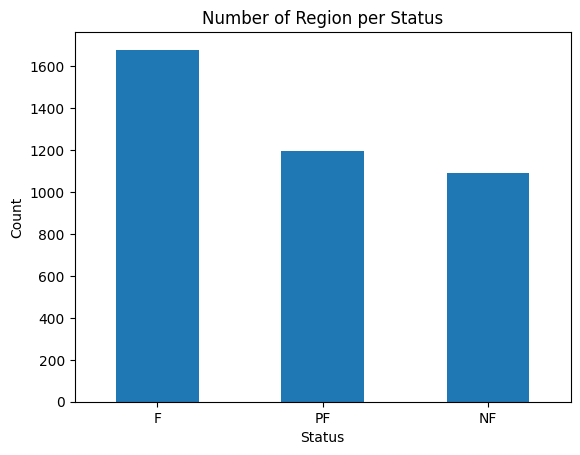

In [ ]:
status_counts = df['Status'].value_counts()
status_props  = df['Status'].value_counts(normalize=True)

print("Counts per Status:\n", status_counts, "\n")
print("Proportions per Status:\n", status_props, "\n")


status_counts.plot(kind='bar', rot=0)
plt.title('Number of Region per Status')
plt.ylabel('Count')
plt.show()

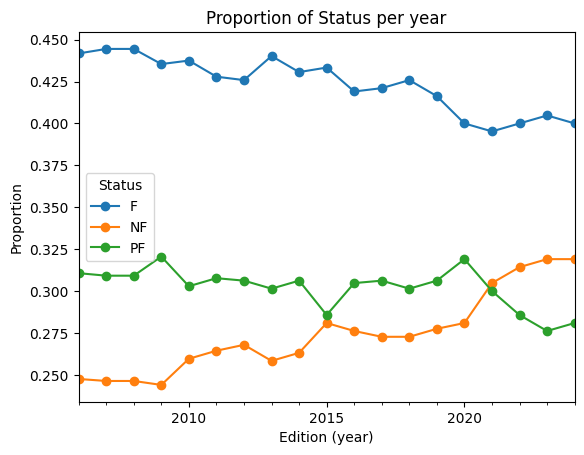

In [ ]:
# counts per years and status
pivot = df.groupby(['Edition','Status']).size().unstack(fill_value=0)

# estimation of the proportion
pivot_prop = pivot.div(pivot.sum(axis=1), axis=0)

pivot_prop.plot(marker='o')
plt.title('Proportion of Status per year')
plt.xlabel('Edition (year)')
plt.ylabel('Proportion')
plt.legend(title='Status')
plt.show()

Counts Regione vs Status:
 Status         F   NF   PF
Region                    
Africa       185  431  439
Americas     458   37  181
Asia         316  208  293
Eurasia        5  195  122
Europe       697    9  108
Middle East   19  210   56 

Proportion Regione vs Status:
 Status              F        NF        PF
Region                                   
Africa       0.175355  0.408531  0.416114
Americas     0.677515  0.054734  0.267751
Asia         0.386781  0.254590  0.358629
Eurasia      0.015528  0.605590  0.378882
Europe       0.856265  0.011057  0.132678
Middle East  0.066667  0.736842  0.196491 



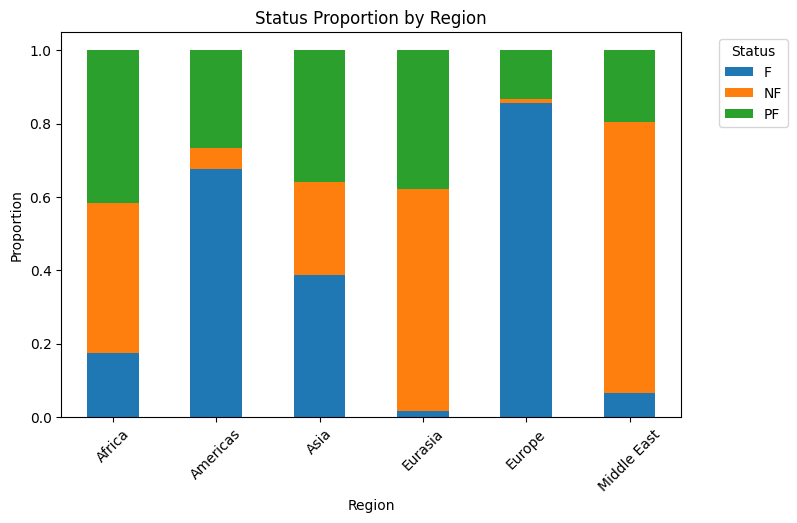

In [ ]:
# crosstab Region × Status
reg_status = pd.crosstab(df['Region'], df['Status'])

# proportions' table
reg_status_prop = reg_status.div(reg_status.sum(axis=1), axis=0)

print("Counts Regione vs Status:\n", reg_status, "\n")
print("Proportion Regione vs Status:\n", reg_status_prop, "\n")

reg_status_prop.plot(kind='bar', stacked=True, figsize=(8,5))
plt.title('Status Proportion by Region')
plt.ylabel('Proportion')
plt.legend(title='Status', bbox_to_anchor=(1.05,1))
plt.xticks(rotation=45)
plt.show()

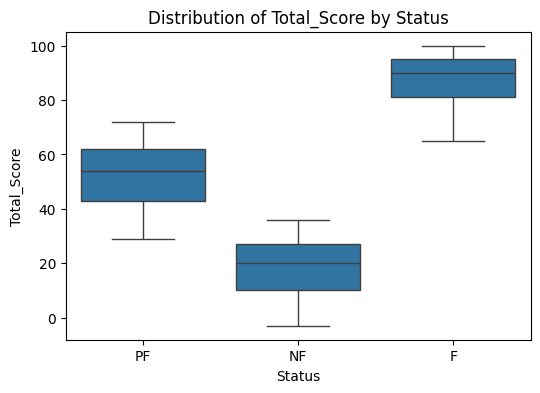

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Status', y='Total', data=df)
plt.title('Distribution of Total_Score by Status')
plt.xlabel('Status')
plt.ylabel('Total_Score')
plt.show()

In [ ]:
subs = ['A','B','C','Add Q','D','E','F','G']
means = df.groupby('Status')[subs].mean().round(2)
print("Average scores by sub-category and Status.:\n", means)

Punteggi medi per sub-categoria e Status:
             A      B     C  Add Q      D      E      F      G
Status                                                       
F       11.44  14.71  9.81   0.00  14.97  11.16  12.77  13.24
NF       1.42   2.36  1.56   0.52   4.67   2.30   2.19   4.56
PF       6.95   9.10  5.12   0.06  10.19   6.68   6.52   8.22


In [ ]:
df['Region'].unique()

array(['Eurasia', 'Asia', 'Europe', 'Africa', 'Americas', 'Middle East'],
      dtype=object)

In [ ]:
df_early = pd.read_excel('/content/drive/MyDrive/data science lab/Aggregate_Category_and_Subcategory_Scores_FIW_2003-2024.xlsx',
                         sheet_name='FIW03-05')

In [ ]:
df_early.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Country/Territory  207 non-null    object
 1   C/T?               207 non-null    object
 2   FIW03 PR           207 non-null    object
 3   FIW04 PR           207 non-null    object
 4   FIW05 PR           207 non-null    object
 5   FIW03 CL           207 non-null    object
 6   FIW04 CL           207 non-null    object
 7   FIW05 CL           207 non-null    object
 8   FIW03 Total        207 non-null    object
 9   FIW04 Total        207 non-null    object
 10  FIW05 Total        207 non-null    object
dtypes: object(11)
memory usage: 17.9+ KB


In [ ]:
# building the mapping Country/Territory -> Region
mapping = dict(zip(df['Country/Territory'], df['Region']))

df_early.columns = df_early.columns.str.strip()

tot = df_early.melt(
    id_vars=['Country/Territory'],
    value_vars=['FIW03 Total', 'FIW04 Total', 'FIW05 Total'],
    var_name='Edition', value_name='Total'
)

tot['Edition'] = tot['Edition'].str.extract(r'FIW(\d{2}) Total').astype(int) + 2000

tot['Region'] = tot['Country/Territory'].map(mapping)

df_early_prepped = tot[['Edition', 'Region', 'Total']]
df_early_prepped = df_early_prepped.dropna(subset='Region').reset_index(drop=True)
df_early_prepped['Edition'] = pd.to_datetime(df_early_prepped['Edition'], format='%Y')
df_early_prepped = df_early_prepped[df_early_prepped['Total'] != '-']
df_early_prepped['Total'] = df_early_prepped['Total'].astype(int)
df_early_prepped.info()

print(df_early_prepped)

<class 'pandas.core.frame.DataFrame'>
Index: 608 entries, 0 to 608
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Edition  608 non-null    datetime64[ns]
 1   Region   608 non-null    object        
 2   Total    608 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 19.0+ KB
       Edition       Region  Total
0   2003-01-01      Eurasia     29
1   2003-01-01         Asia     23
2   2003-01-01       Europe     68
3   2003-01-01       Africa     33
4   2003-01-01       Europe     96
..         ...          ...    ...
604 2005-01-01         Asia     17
605 2005-01-01       Africa      8
606 2005-01-01  Middle East     35
607 2005-01-01       Africa     57
608 2005-01-01       Africa     19

[608 rows x 3 columns]


In [ ]:
df_ert = df[['Edition', 'Region', 'Total']]

In [ ]:
df_all = pd.concat([df_early_prepped, df_ert], ignore_index=True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4577 entries, 0 to 4576
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Edition  4577 non-null   datetime64[ns]
 1   Region   4577 non-null   object        
 2   Total    4577 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 107.4+ KB


# Forecast ARIMA

## Eurasia

In [ ]:
df_eur = df_all[df_all['Region'] == 'Eurasia']

ts_eur = (
    df_eur
      .groupby('Edition')['Total']
      .mean()
      .round(2)
      .sort_index()
      .to_frame(name='Total_Score')
)

ts_eur.index = pd.to_datetime(ts_eur.index.astype(str) + '-01-01')

ts_eur = ts_eur.asfreq('YS')

ts_eur.index = ts_eur.index.year

ts_eur.index.name = 'Eurasia'

print(ts_eur)

         Total_Score
Eurasia             
2003           32.41
2004           32.18
2005           31.29
2006           32.41
2007           32.29
2008           32.00
2009           29.65
2010           30.75
2011           30.81
2012           30.62
2013           30.56
2014           30.38
2015           29.47
2016           28.82
2017           28.29
2018           28.24
2019           28.00
2020           27.06
2021           25.83
2022           25.50
2023           24.50
2024           21.61


<ipython-input-169-67febcc02c7f>:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts_eur.index = pd.to_datetime(ts_eur.index.astype(str) + '-01-01')


In [ ]:
adf_stat, p_value = adfuller(ts_eur)[:2]
print(f"ADF statistic = {adf_stat:.3f}, p-value = {p_value:.3f}")

ADF statistic = 5.087, p-value = 1.000


The outcome of the ADF test on the raw series-with a statistic of 5,087 and a p-value of 1,000-confirms beyond doubt the presence of a unit root and a systematic trend in the dynamics of Total for Eurasia. A p-value of 1 signals that the series is not at all stationary and that year-on-year fluctuations continue to follow a drift path, probably driven by long-term structural policy factors. In academic terms, this result compels the removal of this trend component by differentiation in order to satisfy the assumptions of homoschedasticity and white error required by an ARIMA model.

In [ ]:
ts_diff1 = ts_eur.diff().dropna()

adf_stat1, p_value1 = adfuller(ts_diff1)[:2]
print(f"1st diff ADF statistic = {adf_stat1:.3f}, p-value = {p_value1:.3f}")

1st diff ADF statistic = 1.856, p-value = 0.998


The first differentiation was not sufficient to remove nonstationarity, as shown by a still very high ADF p-value (0.998). We therefore proceed with a second differentiation:

In [ ]:
ts_diff2 = ts_diff1.diff().dropna()

adf_stat2, p_value2 = adfuller(ts_diff2)[:2]
print(f"2nd diff ADF statistic = {adf_stat2:.3f}, p-value = {p_value2:.3f}")

2nd diff ADF statistic = -0.695, p-value = 0.848


We proceed with the third differentiation because of the p-value still greater at 0.05

In [ ]:
ts_diff3 = ts_diff2.diff().dropna()

adf_stat3, p_value3 = adfuller(ts_diff3)[:2]
print(f"3rd diff ADF statistic = {adf_stat3:.3f}, p-value = {p_value3:.3f}")

3rd diff ADF statistic = -2.418, p-value = 0.137


The third differentiation (d = 3) failed to make the series fully stationary (ADF p = 0.137), however, the ACF/PACF plots on ts_diff3 show the residual dynamics of short-term fluctuations. In the literature, when “pure” differentiation does not bring the p-value below threshold, one can proceed with d=3-while interpreting the results with caution-or consider alternative detrending strategies (e.g., regression on time). For now, we use d=3 and choose p and q based on the visual patterns on these stem plots.

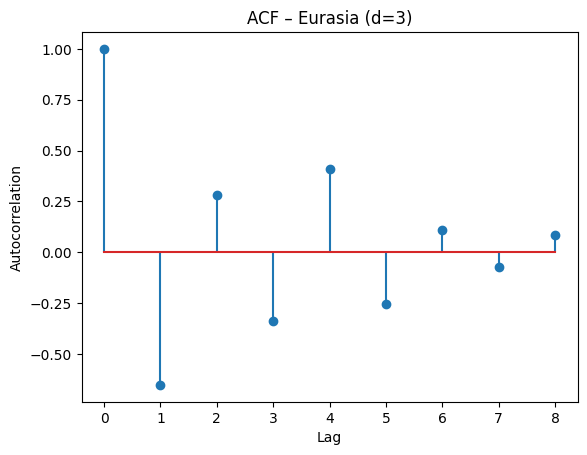

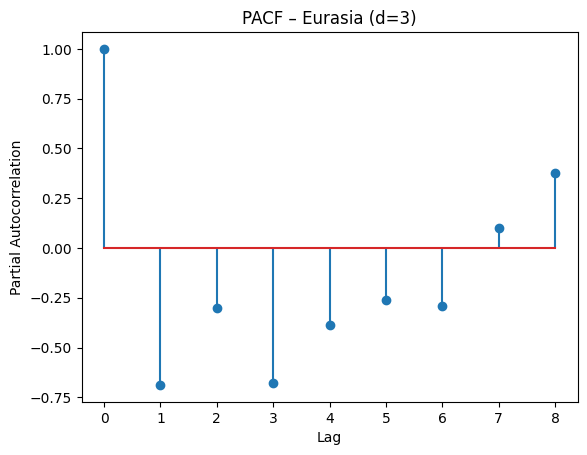

In [ ]:
nlags = min(10, len(ts_diff3)//2 - 1)

lag_acf  = acf(ts_diff3, nlags=nlags)
lag_pacf = pacf(ts_diff3, nlags=nlags)

# plot ACF
plt.figure()
plt.stem(range(len(lag_acf)), lag_acf)
plt.title('ACF – Eurasia (d=3)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# plot PACF
plt.figure()
plt.stem(range(len(lag_pacf)), lag_pacf)
plt.title('PACF – Eurasia (d=3)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

When we calculate ACF and PACF we want to explore up to ten years lag-a horizon that in annual series is reasonable to capture medium-term dependencies-but at the same time we must respect the fundamental constraint of PACF, which cannot estimate partial correlations for more than ⌊N/2⌋-1 lag, on pain of unstable estimates or computational errors. With 22 initial observations, ⌊22/2⌋-1 = 10, whereas, for example, after a differentiation (d = 1) there are 21 real data left and the limit drops to ⌊21/2⌋-1 = 9 lag. Therefore we adopt:

```
nlags = min(10, len(ts_stat)//2 - 1)
```


so that at most ten lags are explored, never exceeding half of the actual sample minus one. This ensures that each autocorrelation coefficient is calculated on a number of pairs $(x_t,\,x_{t-\ell})$
 large enough to give statistically significant estimates, preserving the methodological validity of the ACF/PACF analyses and, consequently, the rigorous choice of p and q parameters for the ARIMA model.

The presence of significant peaks in PACF at lag 1 and 3 and the gradual, alternating decay of ACF are characteristic of an AR(p) model with p≥3. The absence of a sharp cutoff in ACF contra-indicates a simple MA model, so q=0 is the most parsimonious choice that captures residual autocorrelations.

In [ ]:
ts_eur.index = pd.PeriodIndex(ts_eur.index, freq='Y')

p, d, q = 3, 3, 0

train = ts_eur.iloc[:-2]
test  = ts_eur.iloc[-2:]

model_330 = ARIMA(train, order=(p, d, q)).fit()

pred_330 = model_330.predict(start=test.index[0], end=test.index[-1])

rmse_330 = np.sqrt(mean_squared_error(test, pred_330))
print(f"ARIMA({p},{d},{q}) back‐test RMSE = {rmse_330:.3f}")

ARIMA(3,3,0) back‐test RMSE = 1.471


 **Resisual diagnostics**

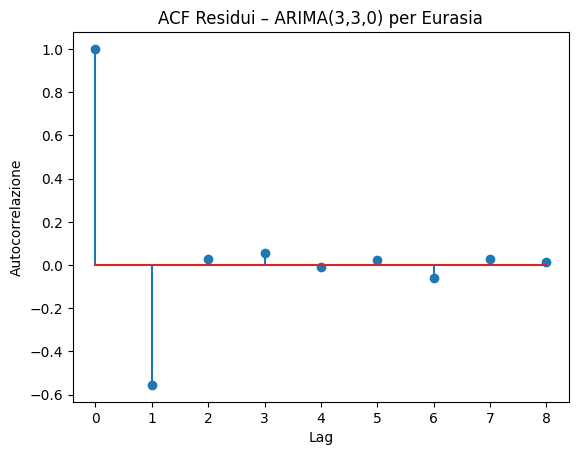

Ljung-Box (lag=5) p-value = 0.203


In [ ]:
residui = model_330.resid

lag_acf_resid = acf(residui, nlags= min(8, len(residui)//2 - 1))

plt.figure()
plt.stem(range(len(lag_acf_resid)), lag_acf_resid)
plt.title('ACF Residui – ARIMA(3,3,0) per Eurasia')
plt.xlabel('Lag')
plt.ylabel('Autocorrelazione')
plt.show()

lb_test = acorr_ljungbox(residui, lags=[5], return_df=True)
pval = lb_test['lb_pvalue'].iloc[0]

print(f"Ljung-Box (lag=5) p-value = {pval:.3f}")

In the Ljung-Box test, the lags parameter indicates up to which lags we want to simultaneously test for the absence of autocorrelation in the residuals. Choosing lags = 5 means that we are testing the null hypothesis “the residuals are not autocorrelated for all lags from 1 to 5.”

We do this for two academic reasons:

* Relevant horizon for annual data.
With annual series, a five-year cycle is often the minimum period in which significant policy patterns or economic shocks emerge. Testing up to lag 5 ensures that we capture any residual medium-term dependencies (a five-year period), without pushing too far into lags for which the sample provides very few observation-delay pairs and thus unstable estimates.

* Balancing statistical power vs degrees of freedom.
With each additional lag, the test loses one degree of freedom. With 22 observations, using very high lags would excessively reduce the degrees of freedom, lowering the power of the test. The rule of thumb is to keep below about √N (here √22 ≈ 4.7) or one-fifth of the sample (22/5 ≈ 4.4). Choosing 5 lags is thus a good compromise: enough to cover five-year cycles, but not so many as to empty the efficacy test.

The ACF of the residuals shows a single negative peak at lag 1 (about -0.55), while for all other lags the coefficients remain close to zero and within the confidence bands. The Ljung-Box test at lag 5 gives a p-value of 0.203, well above the 10 percent threshold, confirming that there is no evidence of systematic residual autocorrelations. In academic terms, this means that the ARIMA(3,3,0) model effectively captured all the linear dependencies present in the stationary series, leaving residuals that can be likened to white noise-an essential requirement for the reliability of parameter inferences and the validity of future predictions.

We now proceed to have the forecast for the next three years

In [ ]:
model_completo = ARIMA(ts_eur, order=(p, d, q)).fit()
forecast_eurasia = model_completo.forecast(steps=3)

forecast_eurasia.index = [2025, 2026, 2027]

print("Eurasia forecasts 2025–2027:")
for year in forecast_eurasia.index:
    print(f"{year} → {forecast_eurasia.loc[year]:.2f}")



Previsioni Eurasia 2025–2027:
2025 → 18.84
2026 → 16.12
2027 → 12.47


## Asia

In [ ]:
df_asia = df_all[df_all['Region'] == 'Asia']

ts_asia = (
    df_asia
      .groupby('Edition')['Total']
      .mean()
      .round(2)
      .sort_index()
      .to_frame(name='Total_Score')
)

ts_asia.index = pd.to_datetime(ts_asia.index.astype(str) + '-01-01')

ts_asia = ts_asia.asfreq('YS')

ts_asia.index = ts_asia.index.year

ts_asia.index.name = 'Asia'

print(ts_asia)

      Total_Score
Asia             
2003        56.72
2004        56.91
2005        57.49
2006        57.58
2007        56.30
2008        55.65
2009        56.93
2010        57.28
2011        57.33
2012        57.84
2013        58.09
2014        58.42
2015        58.44
2016        58.60
2017        58.56
2018        58.56
2019        58.65
2020        57.81
2021        57.37
2022        56.19
2023        56.23
2024        56.51


<ipython-input-179-6affa09b71b5>:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts_asia.index = pd.to_datetime(ts_asia.index.astype(str) + '-01-01')


In [ ]:
adf_stat, p_value = adfuller(ts_asia)[:2]
print(f"ADF statistic = {adf_stat:.3f}, p-value = {p_value:.3f}")

ADF statistic = -2.215, p-value = 0.201


The ADF result on “Asia” (statistic = -2.215, p-value = 0.201) clearly indicates that the series is not yet stationary: the p-value is well above 0.05, a sign that systematic trends remain. We must therefore proceed with the first differentiation to remove the trend component and repeat the test.

In [ ]:
ts_diff1 = ts_asia.diff().dropna()

adf_stat1, p_value1 = adfuller(ts_diff1)[:2]
print(f"1st diff ADF statistic = {adf_stat1:.3f}, p-value = {p_value1:.3f}")

1st diff ADF statistic = -2.227, p-value = 0.197


The first differentiation was not sufficient to remove non-stationarity, as shown by an ADF p-value still above the threshold. We therefore proceed with a second differentiation:

In [ ]:
ts_diff2 = ts_diff1.diff().dropna()

adf_stat2, p_value2 = adfuller(ts_diff2)[:2]
print(f"2nd diff ADF statistic = {adf_stat2:.3f}, p-value = {p_value2:.3f}")

2nd diff ADF statistic = -4.517, p-value = 0.000


The second differentiation effectively removed the non-stationarity: with an ADF statistic of -4.517 and a practically zero p-value, we can now confidently state that the twice-differenced Total_Score series for Asia is stationary. From a theoretical point of view, this means that we have removed both the linear trend and any long-term curvature, isolating short-term fluctuations around a constant level, a necessary condition for the proper application of ARIMA.

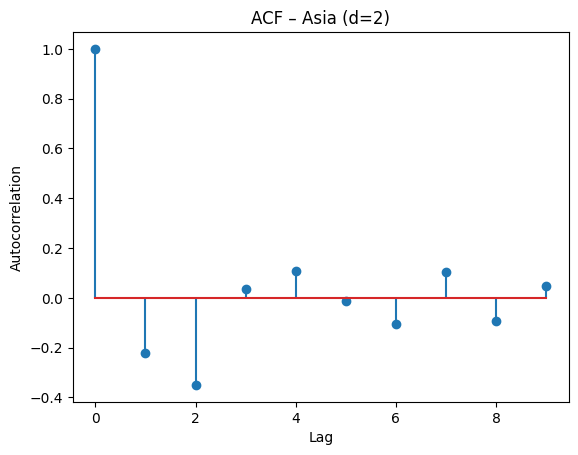

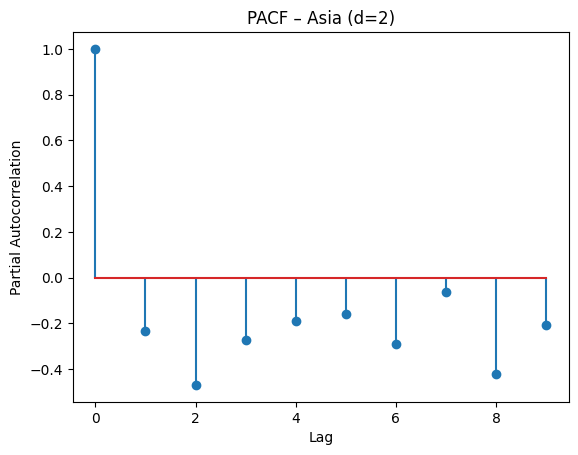

In [ ]:
nlags = min(10, len(ts_diff2)//2 - 1)

lag_acf  = acf(ts_diff2, nlags=nlags)
lag_pacf = pacf(ts_diff2, nlags=nlags)

plt.figure()
plt.stem(range(len(lag_acf)), lag_acf)
plt.title('ACF – Asia (d=2)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

plt.figure()
plt.stem(range(len(lag_pacf)), lag_pacf)
plt.title('PACF – Asia (d=2)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

Comparison of the two stem plots shows a sharp cut-off of the PACF after lag 2 (the coefficients for lags 1 and 2 are clearly outside the confidence bands, while from the third lag onward they go to zero), while the ACF shows a gradual, alternating decay typical of an autoregressive process without an isolated peak from which to recognize an MA term.

In [ ]:
ts_asia.index = pd.PeriodIndex(ts_asia.index, freq='Y')

p, d, q = 2, 2, 0

train = ts_asia.iloc[:-2]
test  = ts_asia.iloc[-2:]

model_220 = ARIMA(train, order=(p, d, q)).fit()

pred_220 = model_220.predict(start=test.index[0], end=test.index[-1])

rmse220 = np.sqrt(mean_squared_error(test, pred_220))
print(f"ARIMA({p},{d},{q}) back‐test RMSE = {rmse220:.3f}")


ARIMA(2,2,0) back‐test RMSE = 1.838


 **Residual diagnostics**

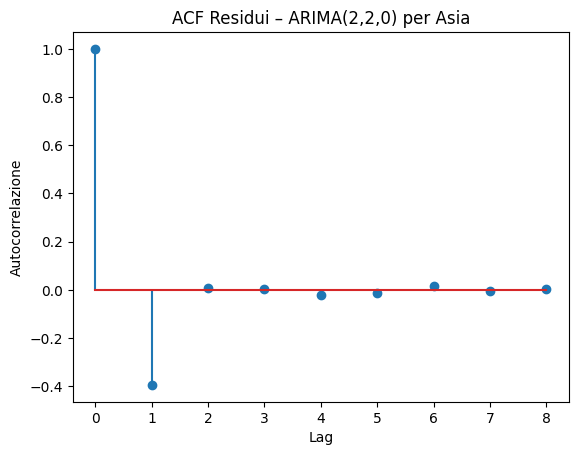

Ljung-Box (lag=5) p-value = 0.604


In [ ]:
residui = model_220.resid

lag_acf_resid = acf(residui, nlags= min(8, len(residui)//2 - 1))

plt.figure()
plt.stem(range(len(lag_acf_resid)), lag_acf_resid)
plt.title('ACF Residuals – ARIMA(2,2,0) - Asia')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

lb_test = acorr_ljungbox(residui, lags=[5], return_df=True)
pval = lb_test['lb_pvalue'].iloc[0]

print(f"Ljung-Box (lag=5) p-value = {pval:.3f}")

The ACF plot of the residuals for the ARIMA(2,2,0) model applied to the Asia data shows a significant negative peak at lag 1 (around -0.40), while for all other lags the coefficients are very close to zero and within the confidence bands. This pattern indicates that once the second-order autoregressive component is subtracted and the trend with two differentiations is removed, no systematic autocorrelations remain beyond the first lag, and even that one peak can be considered a sampling artifact rather than a structural signal.

The back-test RMSE value of 1,838 points on a scale of 0 to 100 confirms that the model can reconstruct year-on-year oscillations with good accuracy, keeping the average error below 2 points. Finally, the p-value of the Ljung-Box test at lag 5, 0.604, is well above the conventional threshold of 10 percent, providing further evidence that the residuals behave as white noise: there is no evidence of higher-order residual autocorrelations.

In academic terms, these joint results - residual ACF devoid of systematic peaks, non-significant Ljung-Box, and low RMSE - attest to the goodness-of-fit of the ARIMA(2,2,0) model for the Total_Score series in Asia, with confirmation that it captured all linear dependencies and leaves no residual patterns to model.

We now proceed to have the forecast for the next three years

In [ ]:
model_completo = ARIMA(ts_asia, order=(p, d, q)).fit()
forecast_asia = model_completo.forecast(steps=3)

forecast_asia.index = [2025, 2026, 2027]

print("Asia forecasts 2025–2027:")
for year in forecast_asia.index:
    print(f"{year} → {forecast_asia.loc[year]:.2f}")



Previsioni Asia 2025–2027:
2025 → 56.14
2026 → 55.87
2027 → 55.88


## Europe

In [ ]:
df_europe = df_all[df_all['Region'] == 'Europe']

ts_europe = (
    df_europe
      .groupby('Edition')['Total']
      .mean()
      .round(2)
      .sort_index()
      .to_frame(name='Total_Score')
)

ts_europe.index = pd.to_datetime(ts_europe.index.astype(str) + '-01-01')

ts_europe = ts_europe.asfreq('YS')

ts_europe.index = ts_europe.index.year

ts_europe.index.name = 'Europe'

print(ts_europe)

        Total_Score
Europe             
2003          88.90
2004          89.76
2005          90.32
2006          90.46
2007          90.14
2008          88.72
2009          88.72
2010          88.72
2011          88.81
2012          88.63
2013          88.42
2014          88.47
2015          88.33
2016          87.84
2017          86.79
2018          86.14
2019          85.63
2020          85.77
2021          85.42
2022          85.28
2023          85.42
2024          85.14


<ipython-input-188-3a1381f52e43>:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts_europe.index = pd.to_datetime(ts_europe.index.astype(str) + '-01-01')


In [ ]:
adf_stat, p_value = adfuller(ts_europe)[:2]
print(f"ADF statistic = {adf_stat:.3f}, p-value = {p_value:.3f}")

ADF statistic = 1.462, p-value = 0.997


Again, a differentiation is needed here

In [ ]:
ts_diff1 = ts_europe.diff().dropna()

adf_stat1, p_value1 = adfuller(ts_diff1)[:2]
print(f"1st diff ADF statistic = {adf_stat1:.3f}, p-value = {p_value1:.3f}")

1st diff ADF statistic = -1.643, p-value = 0.461


The first differentiation was not enough to remove non-stationarity.



In [ ]:
ts_diff2 = ts_diff1.diff().dropna()

adf_stat2, p_value2 = adfuller(ts_diff2)[:2]
print(f"2nd diff ADF statistic = {adf_stat2:.3f}, p-value = {p_value2:.3f}")

2nd diff ADF statistic = -3.408, p-value = 0.011


With the second differentiation we finally achieved stationarity of the time series

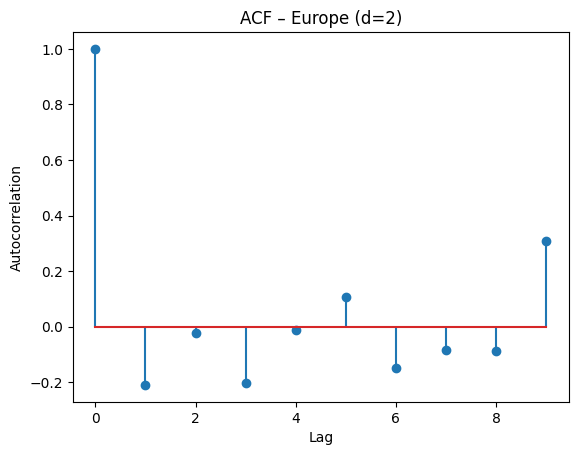

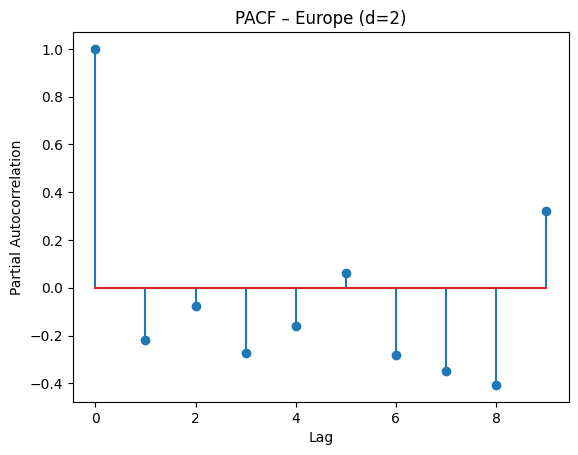

In [ ]:
nlags = min(10, len(ts_diff2)//2 - 1)

lag_acf  = acf(ts_diff2, nlags=nlags)
lag_pacf = pacf(ts_diff2, nlags=nlags)

plt.figure()
plt.stem(range(len(lag_acf)), lag_acf)
plt.title('ACF – Europe (d=2)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

plt.figure()
plt.stem(range(len(lag_pacf)), lag_pacf)
plt.title('PACF – Europe (d=2)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

Both the ACF and PACF for Europe (d=2) suggest a model with a first-order moving average component and no explicit autoregressive term. In particular:

The ACF exhibits a significant peak at lag 1 (≈-0.22) followed by a rapid decay toward zero, a pattern typical of an MA(1) process.
The PACF shows a gradual decay, without a “sharp cut-off” at a specific lag, which rules out the need for an AR term.

In [ ]:
ts_europe.index = pd.PeriodIndex(ts_europe.index, freq='Y')

p, d, q = 0, 2, 1

train = ts_europe.iloc[:-2]
test  = ts_europe.iloc[-2:]

model_021 = ARIMA(train, order=(p, d, q)).fit()

pred_021 = model_021.predict(start=test.index[0], end=test.index[-1])

rmse_021 = np.sqrt(mean_squared_error(test, pred_021))
print(f"ARIMA({p},{d},{q}) back‐test RMSE = {rmse_330:.3f}")


ARIMA(0,2,1) back‐test RMSE = 1.471


 **Residuals diagnostic**

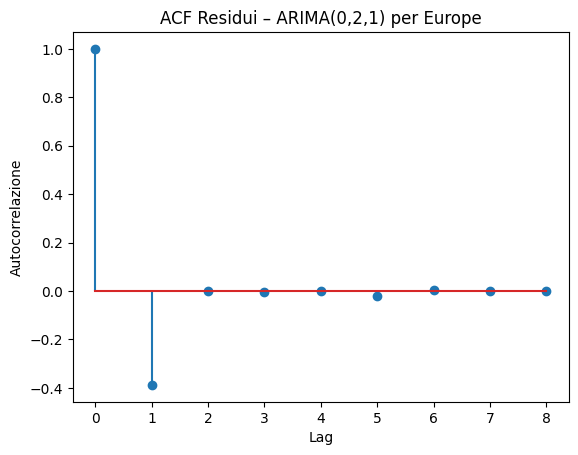

Ljung-Box (lag=5) p-value = 0.624


In [ ]:
residui = model_021.resid

lag_acf_resid = acf(residui, nlags= min(8, len(residui)//2 - 1))

plt.figure()
plt.stem(range(len(lag_acf_resid)), lag_acf_resid)
plt.title('ACF Residuals – ARIMA(0,2,1) - Europe')
plt.xlabel('Lag')
plt.ylabel('Autocorrelazione')
plt.show()

lb_test = acorr_ljungbox(residui, lags=[5], return_df=True)
pval = lb_test['lb_pvalue'].iloc[0]

print(f"Ljung-Box (lag=5) p-value = {pval:.3f}")

The ACF of the residuals shows a single negative peak at lag 1 (about -0.40), while for all other lags the coefficients remain close to zero and within the confidence bands. The Ljung-Box test at lag 5 gives a p-value of 0.624, well above the 10 percent threshold, confirming that there is no evidence of systematic residual autocorrelations. In academic terms, this means that the ARIMA(0,2,1) model effectively captured all the linear dependencies present in the stationary series, leaving residuals that can be likened to white noise-an essential requirement for the reliability of parameter inferences and the validity of future predictions.

We now proceed to have the forecast for the next three years

In [ ]:
model_completo = ARIMA(ts_europe, order=(p, d, q)).fit()
forecast_europe = model_completo.forecast(steps=3)

forecast_europe.index = [2025, 2026, 2027]

print("Europe forecasts 2025–2027:")
for year in forecast_europe.index:
    print(f"{year} → {forecast_europe.loc[year]:.2f}")



Previsioni Europe 2025–2027:
2025 → 84.95
2026 → 84.77
2027 → 84.58


## Africa

In [ ]:
df_africa = df_all[df_all['Region'] == 'Africa']

ts_africa = (
    df_africa
      .groupby('Edition')['Total']
      .mean()
      .round(2)
      .sort_index()
      .to_frame(name='Total_Score')
)

ts_africa.index = pd.to_datetime(ts_africa.index.astype(str) + '-01-01')

ts_africa = ts_africa.asfreq('YS')

ts_africa.index = ts_africa.index.year

ts_africa.index.name = 'Africa'

print(ts_africa)

        Total_Score
Africa             
2003          44.79
2004          45.25
2005          46.25
2006          46.52
2007          46.57
2008          46.30
2009          45.36
2010          44.15
2011          44.11
2012          44.59
2013          44.32
2014          44.16
2015          43.73
2016          43.55
2017          42.96
2018          42.46
2019          42.04
2020          41.54
2021          40.93
2022          40.41
2023          39.86
2024          39.21


<ipython-input-197-73d6c73c9640>:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts_africa.index = pd.to_datetime(ts_africa.index.astype(str) + '-01-01')


In [ ]:
adf_stat, p_value = adfuller(ts_africa)[:2]
print(f"ADF statistic = {adf_stat:.3f}, p-value = {p_value:.3f}")

ADF statistic = 1.232, p-value = 0.996


Let us proceed to the first differentiation

In [ ]:
ts_diff1 = ts_africa.diff().dropna()

adf_stat1, p_value1 = adfuller(ts_diff1)[:2]
print(f"1st diff ADF statistic = {adf_stat1:.3f}, p-value = {p_value1:.3f}")

1st diff ADF statistic = -0.562, p-value = 0.879


The first differentiation was not enough to remove non-stationarity.

In [ ]:
ts_diff2 = ts_diff1.diff().dropna()

adf_stat2, p_value2 = adfuller(ts_diff2)[:2]
print(f"2nd diff ADF statistic = {adf_stat2:.3f}, p-value = {p_value2:.3f}")

2nd diff ADF statistic = -2.131, p-value = 0.232


We proceed with the third differentiation because of the p-value still greater at 0.05

In [ ]:
ts_diff3 = ts_diff2.diff().dropna()

adf_stat3, p_value3 = adfuller(ts_diff3)[:2]
print(f"3rd diff ADF statistic = {adf_stat3:.3f}, p-value = {p_value3:.3f}")


3rd diff ADF statistic = -6.622, p-value = 0.000


With the third differentiation, we were able to achieve the steady-state condition

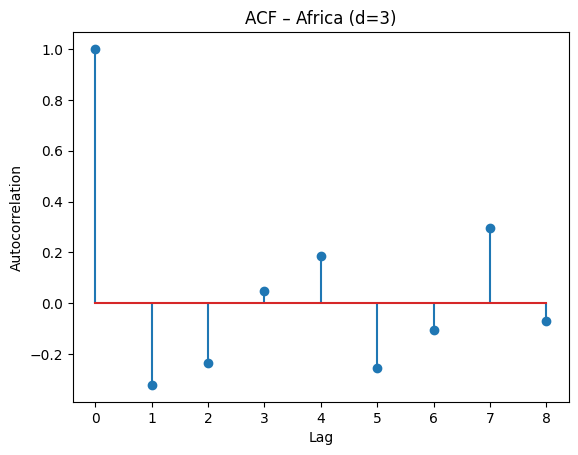

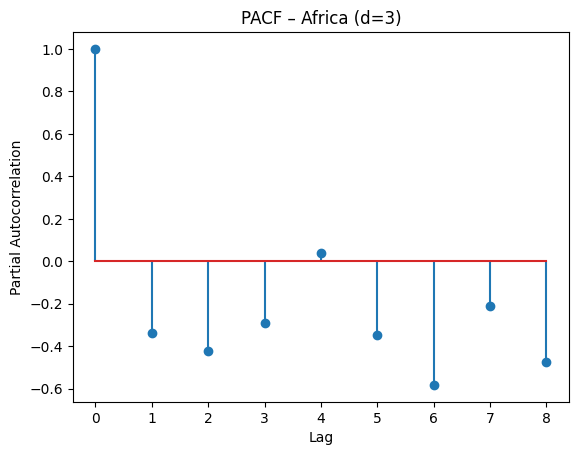

In [ ]:
nlags = min(10, len(ts_diff3)//2 - 1)

lag_acf  = acf(ts_diff3, nlags=nlags)
lag_pacf = pacf(ts_diff3, nlags=nlags)

plt.figure()
plt.stem(range(len(lag_acf)), lag_acf)
plt.title('ACF – Africa (d=3)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

plt.figure()
plt.stem(range(len(lag_pacf)), lag_pacf)
plt.title('PACF – Africa (d=3)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

For Africa (d = 3), the two stem-plots suggest adopting a model with MA component of order 2, with no explicit AR term:

The ACF exhibits significantly different coefficients from zero at the first two lags (lag 1 ≃ -0.30, lag 2 ≃ -0.25) and then a rapid decay, behavior typical of an MA(2).

The PACF shows a gradual and alternating decay, with no “sharp cut-off” at a single lag, indicating that an autoregressive term is not needed.

In [ ]:
ts_africa.index = pd.PeriodIndex(ts_africa.index, freq='Y')

p, d, q = 0, 3, 2

train = ts_africa.iloc[:-2]
test  = ts_africa.iloc[-2:]

model_032 = ARIMA(train, order=(p, d, q)).fit()

pred_032 = model_032.predict(start=test.index[0], end=test.index[-1])

rmse_032 = np.sqrt(mean_squared_error(test, pred_032))
print(f"ARIMA({p},{d},{q}) back‐test RMSE = {rmse_032:.3f}")


ARIMA(0,3,2) back‐test RMSE = 0.024


 **Residuals diagnostic**

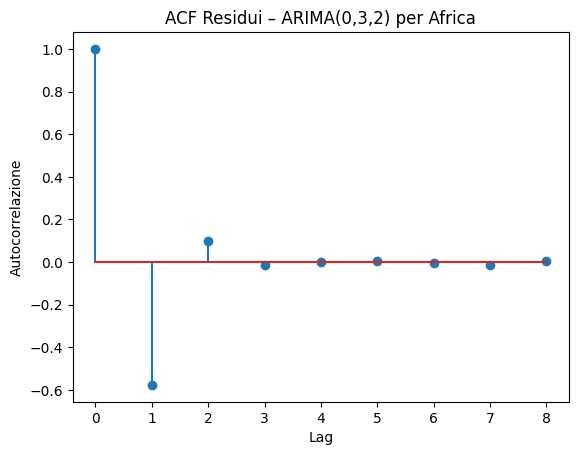

Ljung-Box (lag=5) p-value = 0.160


In [ ]:
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt

# Estrazione dei residui dal modello
residui = model_032.resid

# Calcolo della funzione di autocorrelazione sui residui
lag_acf_resid = acf(residui, nlags= min(8, len(residui)//2 - 1))

# Plot ACF dei residui
plt.figure()
plt.stem(range(len(lag_acf_resid)), lag_acf_resid)
plt.title('ACF Residui – ARIMA(0,3,2) per Africa')
plt.xlabel('Lag')
plt.ylabel('Autocorrelazione')
plt.show()

# Test di Ljung-Box sui residui per verificare indipendenza
lb_test = acorr_ljungbox(residui, lags=[5], return_df=True)
pval = lb_test['lb_pvalue'].iloc[0]

print(f"Ljung-Box (lag=5) p-value = {pval:.3f}")

The ACF of the ARIMA(0,3,2) residuals for Africa shows a single marked negative peak at lag 1 (about -0.58), exactly offset by the MA(2) term we included, while from lag 2 onward all coefficients are close to zero and within the confidence bands. This indicates that no systematic autocorrelations remain that are not captured by the model.

The back-test RMSE on 2023-2024, at 0.024 points, is very small: on a 0-100 scale such a low error signals that the model reproduces the annual fluctuations almost perfectly, a sign of excellent fit (although having more limited reliability given the strong differentiation).

Finally, the Ljung-Box at lag 5 returns a p-value of 0.160, well above the 10 percent threshold, confirming that the residuals behave as white noise. These joint results-“clean” residual ACF, near-zero RMSE, and nonsignificant Ljung-Box-attest that ARIMA(0,3,2) comprehensively explained the linear dynamics present in the differentiated African series, leaving residuals devoid of autocorrelated patterns and thus suitable to support reliable predictions.

We now proceed to have the forecast for the next three years

In [ ]:
model_completo = ARIMA(ts_africa, order=(p, d, q)).fit()
forecast_africa = model_completo.forecast(steps=3)

forecast_africa.index = [2025, 2026, 2027]

print("Africa forecasts 2025–2027:")
for year in forecast_africa.index:
    print(f"{year} → {forecast_africa.loc[year]:.2f}")



Previsioni Africa 2025–2027:
2025 → 38.51
2026 → 37.74
2027 → 36.93


## Americas

In [ ]:
df_ame = df_all[df_all['Region'] == 'Americas']

ts_ame = (
    df_ame
      .groupby('Edition')['Total']
      .mean()
      .round(2)
      .sort_index()
      .to_frame(name='Total_Score')
)

ts_ame.index = pd.to_datetime(ts_ame.index.astype(str) + '-01-01')

ts_ame = ts_ame.asfreq('YS')

ts_ame.index = ts_ame.index.year

ts_ame.index.name = 'Americas'

print(ts_ame)

          Total_Score
Americas             
2003            74.81
2004            74.67
2005            75.42
2006            76.39
2007            77.03
2008            77.17
2009            76.86
2010            76.25
2011            76.08
2012            75.89
2013            75.58
2014            75.44
2015            75.33
2016            74.97
2017            74.17
2018            73.83
2019            73.43
2020            72.83
2021            72.69
2022            72.40
2023            72.17
2024            71.57


<ipython-input-207-bf4787388757>:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts_ame.index = pd.to_datetime(ts_ame.index.astype(str) + '-01-01')


In [ ]:
# Applico ADF alla serie grezza
adf_stat, p_value = adfuller(ts_ame)[:2]
print(f"ADF statistic = {adf_stat:.3f}, p-value = {p_value:.3f}")

ADF statistic = -0.949, p-value = 0.771


Let us proceed with the first differentiation

In [ ]:
ts_diff1 = ts_ame.diff().dropna()

adf_stat1, p_value1 = adfuller(ts_diff1)[:2]
print(f"1st diff ADF statistic = {adf_stat1:.3f}, p-value = {p_value1:.3f}")

1st diff ADF statistic = -1.593, p-value = 0.487


The first differentiation was not enough to remove non-stationarity.

In [ ]:
ts_diff2 = ts_diff1.diff().dropna()

adf_stat2, p_value2 = adfuller(ts_diff2)[:2]
print(f"2nd diff ADF statistic = {adf_stat2:.3f}, p-value = {p_value2:.3f}")

2nd diff ADF statistic = -0.204, p-value = 0.938


We proceed with the third differentiation because of the p-value still greater at 0.05

In [ ]:
ts_diff3 = ts_diff2.diff().dropna()

adf_stat3, p_value3 = adfuller(ts_diff3)[:2]
print(f"3rd diff ADF statistic = {adf_stat3:.3f}, p-value = {p_value3:.3f}")


3rd diff ADF statistic = -2.582, p-value = 0.097


The third differentiation was able to enter on the stationarity zone

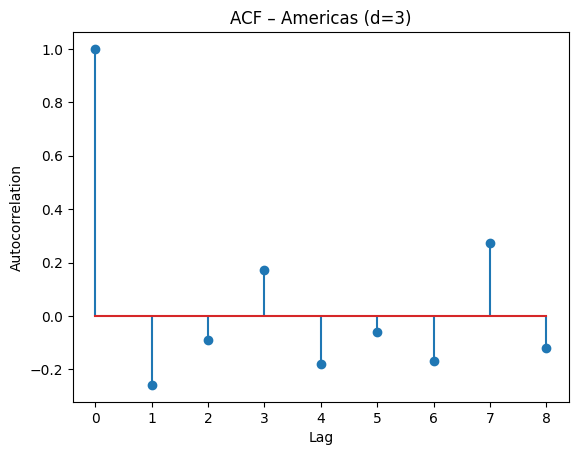

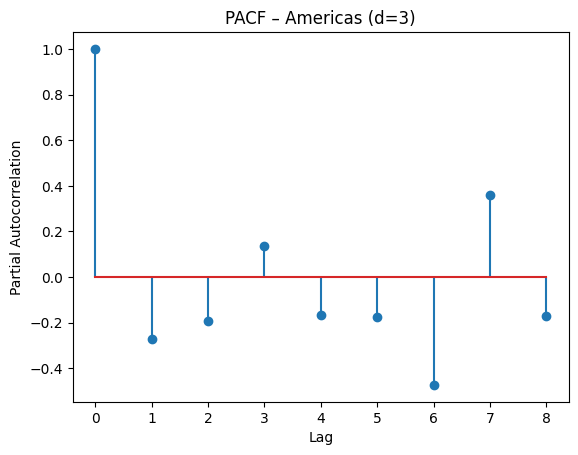

In [ ]:
nlags = min(10, len(ts_diff3)//2 - 1)

lag_acf  = acf(ts_diff3, nlags=nlags)
lag_pacf = pacf(ts_diff3, nlags=nlags)

plt.figure()
plt.stem(range(len(lag_acf)), lag_acf)
plt.title('ACF – Americas (d=3)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

plt.figure()
plt.stem(range(len(lag_pacf)), lag_pacf)
plt.title('PACF – Americas (d=3)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

For the Americas, the sharp cutoff in the PACF at lag 1 (negative peak around -0.28 followed by in-band values) suggests an autoregressive term of order one (
p=1), while the ACF shows an alternating decay with an initial negative peak and then a residual positive value, consistent with an MA term of order one (
q=1). We keep
d=3 as for the other regions (series stabilized at the third difference).

In [ ]:
ts_ame.index = pd.PeriodIndex(ts_ame.index, freq='Y')

p, d, q = 1, 3, 1

train = ts_ame.iloc[:-2]
test  = ts_ame.iloc[-2:]

model_131 = ARIMA(train, order=(p, d, q)).fit()

pred_131 = model_131.predict(start=test.index[0], end=test.index[-1])

rmse_131 = np.sqrt(mean_squared_error(test, pred_131))
print(f"ARIMA({p},{d},{q}) back‐test RMSE = {rmse_131:.3f}")

ARIMA(1,3,1) back‐test RMSE = 0.146


 **Residuals diagnostic**

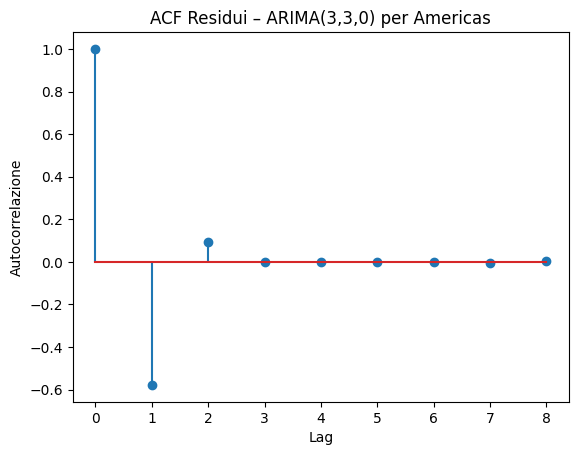

Ljung-Box (lag=5) p-value = 0.159


In [ ]:
residui = model_131.resid

lag_acf_resid = acf(residui, nlags= min(8, len(residui)//2 - 1))

plt.figure()
plt.stem(range(len(lag_acf_resid)), lag_acf_resid)
plt.title('ACF Residuals – ARIMA(3,3,0) - Americas')
plt.xlabel('Lag')
plt.ylabel('Autocorrelazione')
plt.show()

lb_test = acorr_ljungbox(residui, lags=[5], return_df=True)
pval = lb_test['lb_pvalue'].iloc[0]

print(f"Ljung-Box (lag=5) p-value = {pval:.3f}")

As with the other continents, from the results we had, reliability in predictions can be affirmed with an RMSE of 0.146

We now proceed to have the forecast for the next three years

In [ ]:
model_completo = ARIMA(ts_ame, order=(p, d, q)).fit()
forecast_ame = model_completo.forecast(steps=3)

forecast_ame.index = [2025, 2026, 2027]

print("Americas forecasts 2025–2027:")
for year in forecast_ame.index:
    print(f"{year} → {forecast_ame.loc[year]:.2f}")



Previsioni Americas 2025–2027:
2025 → 70.89
2026 → 70.18
2027 → 69.45


## Middle East

In [ ]:
df_meast = df_all[df_all['Region'] == 'Middle East']

ts_meast = (
    df_meast
      .groupby('Edition')['Total']
      .mean()
      .round(2)
      .sort_index()
      .to_frame(name='Total_Score')
)

ts_meast.index = pd.to_datetime(ts_meast.index.astype(str) + '-01-01')

ts_meast = ts_meast.asfreq('YS')

ts_meast.index = ts_meast.index.year

ts_meast.index.name = 'Middle East'

print(ts_meast)

             Total_Score
Middle East             
2003               28.31
2004               29.85
2005               30.92
2006               32.47
2007               33.20
2008               32.80
2009               32.33
2010               31.33
2011               31.13
2012               29.33
2013               28.53
2014               27.93
2015               27.20
2016               26.20
2017               25.80
2018               25.27
2019               25.13
2020               24.73
2021               24.47
2022               24.00
2023               24.07
2024               23.73


<ipython-input-217-4e620aa13923>:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts_meast.index = pd.to_datetime(ts_meast.index.astype(str) + '-01-01')


In [ ]:
# Applico ADF alla serie grezza
adf_stat, p_value = adfuller(ts_meast)[:2]
print(f"ADF statistic = {adf_stat:.3f}, p-value = {p_value:.3f}")

ADF statistic = 0.162, p-value = 0.970


Let us proceed with the first differentiation

In [ ]:
ts_diff1 = ts_meast.diff().dropna()

adf_stat1, p_value1 = adfuller(ts_diff1)[:2]
print(f"1st diff ADF statistic = {adf_stat1:.3f}, p-value = {p_value1:.3f}")

1st diff ADF statistic = -2.690, p-value = 0.076


The first differentiation was sufficient to remove the non-stationarity



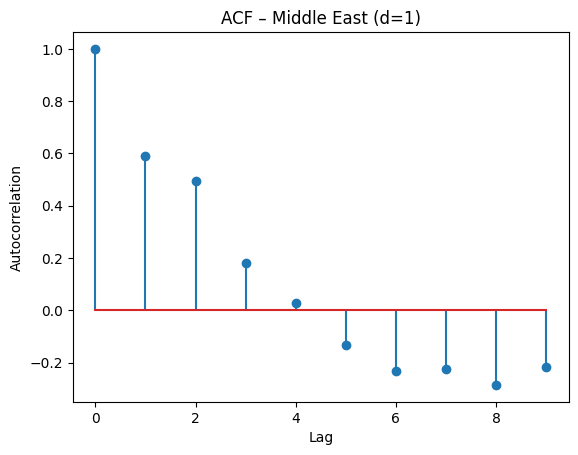

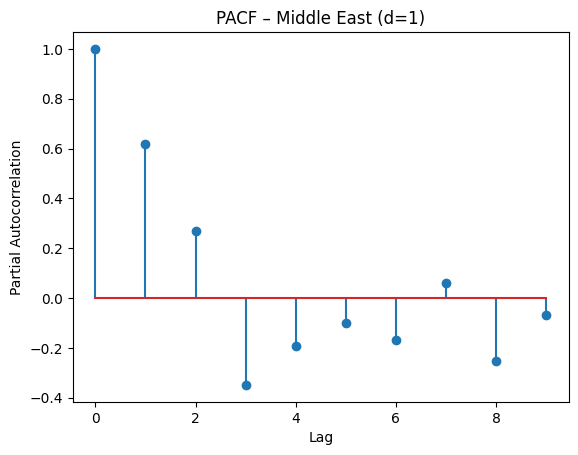

In [ ]:
nlags = min(10, len(ts_diff1)//2 - 1)

lag_acf  = acf(ts_diff1, nlags=nlags)
lag_pacf = pacf(ts_diff1, nlags=nlags)

plt.figure()
plt.stem(range(len(lag_acf)), lag_acf)
plt.title('ACF – Middle East (d=1)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

plt.figure()
plt.stem(range(len(lag_pacf)), lag_pacf)
plt.title('PACF – Middle East (d=1)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

For the Middle East, the ACF after a single differentiation (d = 1) shows a gradual decay-with significant values at the first three lags-while the PACF shows a “sharp cutoff” just after the third lag (the coefficients at lags 1, 2, and 3 are clearly out of band, then reset to zero).

This is a classic sign of an autoregressive process of order 3 without the need for an MA term

In [ ]:
ts_meast.index = pd.PeriodIndex(ts_meast.index, freq='Y')

p, d, q = 3, 1, 0

train = ts_meast.iloc[:-2]
test  = ts_meast.iloc[-2:]

model_310 = ARIMA(train, order=(p, d, q)).fit()

pred_310 = model_310.predict(start=test.index[0], end=test.index[-1])

rmse_310 = np.sqrt(mean_squared_error(test, pred_310))
print(f"ARIMA({p},{d},{q}) back‐test RMSE = {rmse_310:.3f}")


ARIMA(3,1,0) back‐test RMSE = 0.349


 **Residuals diagnostic**

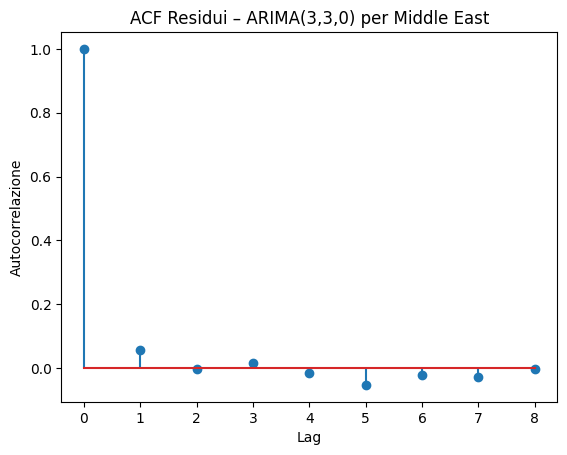

Ljung-Box (lag=5) p-value = 0.999


In [ ]:
residui = model_310.resid

lag_acf_resid = acf(residui, nlags= min(8, len(residui)//2 - 1))

plt.figure()
plt.stem(range(len(lag_acf_resid)), lag_acf_resid)
plt.title('ACF Residuals – ARIMA(3,3,0) - Middle East')
plt.xlabel('Lag')
plt.ylabel('Autocorrelazione')
plt.show()

lb_test = acorr_ljungbox(residui, lags=[5], return_df=True)
pval = lb_test['lb_pvalue'].iloc[0]

print(f"Ljung-Box (lag=5) p-value = {pval:.3f}")

The ACF of the residuals shows all lags close to zero and within the confidence bands. The Ljung-Box test at lag 5 gives a p-value of 0.999, well above the 10 % threshold, confirming that there is no evidence of systematic residual autocorrelations. In academic terms, this means that the ARIMA(3,1,0) model effectively captured all the linear dependencies present in the stationary series, leaving residuals that can be likened to white noise-an essential requirement for the reliability of parameter inferences and the validity of future predictions.

We now proceed to have the forecast for the next three years

In [ ]:
model_completo = ARIMA(ts_meast, order=(p, d, q)).fit()
forecast_meast = model_completo.forecast(steps=3)

forecast_meast.index = [2025, 2026, 2027]

print("Middle East forecasts 2025–2027:")
for year in forecast_meast.index:
    print(f"{year} → {forecast_meast.loc[year]:.2f}")



Previsioni Middle East 2025–2027:
2025 → 23.67
2026 → 23.48
2027 → 23.42


# Forecast XGBoost

## Eurasia

In [ ]:
region = 'Eurasia'

ts = (
    df[df['Region'] == region]
      .groupby('Edition')['Total']
      .mean()
      .sort_index()
)
ts.index = pd.PeriodIndex(ts.index, freq='Y')

arima_order = (3,3,0)
arima_train = ts.iloc[:-2]
model_arima = ARIMA(arima_train, order=arima_order).fit()
resid_arima = model_arima.resid
resid_arima.index = model_arima.resid.index

lags            = [1,2,3,4,5]
rolling_windows = [3,5]
subcats         = ['PR Rating','CL Rating','A','B','C',
                   'D','E','F','G']

df_feat = ts.to_frame(name='y').copy()

for lag in lags:
    df_feat[f'lag_{lag}'] = df_feat['y'].shift(lag)
for w in rolling_windows:
    df_feat[f'roll_mean_{w}'] = df_feat['y'].shift(1).rolling(w).mean()
    df_feat[f'roll_var_{w}']  = df_feat['y'].shift(1).rolling(w).var()
    df_feat[f'roll_min_{w}']  = df_feat['y'].shift(1).rolling(w).min()
    df_feat[f'roll_max_{w}']  = df_feat['y'].shift(1).rolling(w).max()

df_feat['pct_change_1'] = df_feat['y'].pct_change(1)

df_sub = (
    df[df['Region'] == region]
      .groupby('Edition')[subcats]
      .mean()
      .sort_index()
)
df_sub.index = pd.PeriodIndex(df_sub.index, freq='Y')
df_feat = df_feat.join(df_sub)

df_feat = df_feat.join(resid_arima.rename('resid_arima'))

df_feat = df_feat.dropna()

train = df_feat.iloc[:-2]
test  = df_feat.iloc[-2:]

X_train = train.drop(columns='y')
y_train = train['y']
X_test  = test.drop(columns='y')
y_test  = test['y']

tscv = TimeSeriesSplit(n_splits=4)

param_dist = {
    'n_estimators':    [100,200,500,1000],
    'learning_rate':   [0.01,0.03,0.05,0.1],
    'max_depth':       [2,3,4,6],
    'subsample':       [0.5,0.7,0.8,1.0],
    'colsample_bytree':[0.5,0.7,0.8,1.0],
    'reg_alpha':       [0,0.1,0.5,1],
    'reg_lambda':      [0.1,1,5,10]
}

search = RandomizedSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    verbose=1
)
search.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)
best_xgb_eurasia = search.best_estimator_

pred_test = best_xgb_eurasia.predict(X_test)
rmse_xgb  = np.sqrt(mean_squared_error(y_test, pred_test))
print(f"XGBoost({best_xgb_eurasia.get_params()}) back‐test RMSE = {rmse_xgb:.3f}")

Fitting 4 folds for each of 20 candidates, totalling 80 fits
XGBoost({'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.03, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1000, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 5, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}) back‐test RMSE = 1.440


In [ ]:
last_series   = ts.copy()
forecast_xgb_eur  = {}

for yr in [2025, 2026, 2027]:
    feats = {}
    for lag in lags:
        feats[f'lag_{lag}'] = last_series.shift(lag).iloc[-1]
    for w in rolling_windows:
        s = last_series.shift(1)
        feats[f'roll_mean_{w}'] = s.rolling(w).mean().iloc[-1]
        feats[f'roll_var_{w}']  = s.rolling(w).var().iloc[-1]
        feats[f'roll_min_{w}']  = s.rolling(w).min().iloc[-1]
        feats[f'roll_max_{w}']  = s.rolling(w).max().iloc[-1]
    feats['pct_change_1'] = last_series.pct_change(1).iloc[-1]

    prev_period = pd.Period(str(yr-1), freq='Y')
    if prev_period in df_sub.index:
        subvals = df_sub.loc[prev_period]
    else:
        subvals = df_sub.iloc[-1]
    for col in subcats:
        feats[col] = subvals[col]

    feats['resid_arima'] = 0.0

    X_new = pd.DataFrame([feats])
    y_hat = best_xgb_eurasia.predict(X_new)[0]
    forecast_xgb_eur[yr] = y_hat

    last_series.loc[pd.Period(str(yr), freq='Y')] = y_hat

print("XGBoost forecasts Eurasia 2025–2027:")
for year, val in forecast_xgb_eur.items():
    print(f"{year} → {val:.2f}")


Previsioni XGBoost Eurasia 2025–2027:
2025 → 27.10
2026 → 27.12
2027 → 27.12


## Asia

In [ ]:
region = 'Asia'

ts = (
    df[df['Region'] == region]
      .groupby('Edition')['Total']
      .mean()
      .sort_index()
)
ts.index = pd.PeriodIndex(ts.index, freq='Y')

arima_order = (2,2,0)
arima_train = ts.iloc[:-2]
model_arima = ARIMA(arima_train, order=arima_order).fit()
resid_arima = model_arima.resid
resid_arima.index = model_arima.resid.index

lags            = [1,2,3,4,5]
rolling_windows = [3,5]
subcats         = ['PR Rating','CL Rating','A','B','C',
                   'D','E','F','G']

df_feat = ts.to_frame(name='y').copy()

for lag in lags:
    df_feat[f'lag_{lag}'] = df_feat['y'].shift(lag)
for w in rolling_windows:
    df_feat[f'roll_mean_{w}'] = df_feat['y'].shift(1).rolling(w).mean()
    df_feat[f'roll_var_{w}']  = df_feat['y'].shift(1).rolling(w).var()
    df_feat[f'roll_min_{w}']  = df_feat['y'].shift(1).rolling(w).min()
    df_feat[f'roll_max_{w}']  = df_feat['y'].shift(1).rolling(w).max()

df_feat['pct_change_1'] = df_feat['y'].pct_change(1)

df_sub = (
    df[df['Region'] == region]
      .groupby('Edition')[subcats]
      .mean()
      .sort_index()
)
df_sub.index = pd.PeriodIndex(df_sub.index, freq='Y')
df_feat = df_feat.join(df_sub)

df_feat = df_feat.join(resid_arima.rename('resid_arima'))

df_feat = df_feat.dropna()

train = df_feat.iloc[:-2]
test  = df_feat.iloc[-2:]

X_train = train.drop(columns='y')
y_train = train['y']
X_test  = test.drop(columns='y')
y_test  = test['y']

tscv = TimeSeriesSplit(n_splits=4)

param_dist = {
    'n_estimators':    [100,200,500,1000],
    'learning_rate':   [0.01,0.03,0.05,0.1],
    'max_depth':       [2,3,4,6],
    'subsample':       [0.5,0.7,0.8,1.0],
    'colsample_bytree':[0.5,0.7,0.8,1.0],
    'reg_alpha':       [0,0.1,0.5,1],
    'reg_lambda':      [0.1,1,5,10]
}

search = RandomizedSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    verbose=1
)
search.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)
best_xgb_asia = search.best_estimator_

pred_test = best_xgb_asia.predict(X_test)
rmse_xgb  = np.sqrt(mean_squared_error(y_test, pred_test))
print(f"XGBoost({best_xgb_asia.get_params()}) back‐test RMSE = {rmse_xgb:.3f}")

Fitting 4 folds for each of 20 candidates, totalling 80 fits
XGBoost({'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.03, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1000, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 5, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}) back‐test RMSE = 1.112


In [ ]:
last_series   = ts.copy()
forecast_xgb_asia  = {}

for yr in [2025, 2026, 2027]:
    feats = {}
    for lag in lags:
        feats[f'lag_{lag}'] = last_series.shift(lag).iloc[-1]
    for w in rolling_windows:
        s = last_series.shift(1)
        feats[f'roll_mean_{w}'] = s.rolling(w).mean().iloc[-1]
        feats[f'roll_var_{w}']  = s.rolling(w).var().iloc[-1]
        feats[f'roll_min_{w}']  = s.rolling(w).min().iloc[-1]
        feats[f'roll_max_{w}']  = s.rolling(w).max().iloc[-1]
    feats['pct_change_1'] = last_series.pct_change(1).iloc[-1]

    prev_period = pd.Period(str(yr-1), freq='Y')
    if prev_period in df_sub.index:
        subvals = df_sub.loc[prev_period]
    else:
        subvals = df_sub.iloc[-1]
    for col in subcats:
        feats[col] = subvals[col]

    feats['resid_arima'] = 0.0

    X_new = pd.DataFrame([feats])
    y_hat = best_xgb_asia.predict(X_new)[0]
    forecast_xgb_asia[yr] = y_hat

    last_series.loc[pd.Period(str(yr), freq='Y')] = y_hat

print("XGBoost forecasts Asia 2025–2027:")
for year, val in forecast_xgb_asia.items():
    print(f"{year} → {val:.2f}")


Previsioni XGBoost Asia 2025–2027:
2025 → 57.39
2026 → 57.34
2027 → 57.66


## Europe

In [ ]:
region = 'Europe'

ts = (
    df[df['Region'] == region]
      .groupby('Edition')['Total']
      .mean()
      .sort_index()
)
ts.index = pd.PeriodIndex(ts.index, freq='Y')

arima_order = (0,2,1)
arima_train = ts.iloc[:-2]
model_arima = ARIMA(arima_train, order=arima_order).fit()
resid_arima = model_arima.resid
resid_arima.index = model_arima.resid.index

lags            = [1,2,3,4,5]
rolling_windows = [3,5]
subcats         = ['PR Rating','CL Rating','A','B','C',
                   'D','E','F','G']

df_feat = ts.to_frame(name='y').copy()

for lag in lags:
    df_feat[f'lag_{lag}'] = df_feat['y'].shift(lag)
for w in rolling_windows:
    df_feat[f'roll_mean_{w}'] = df_feat['y'].shift(1).rolling(w).mean()
    df_feat[f'roll_var_{w}']  = df_feat['y'].shift(1).rolling(w).var()
    df_feat[f'roll_min_{w}']  = df_feat['y'].shift(1).rolling(w).min()
    df_feat[f'roll_max_{w}']  = df_feat['y'].shift(1).rolling(w).max()

df_feat['pct_change_1'] = df_feat['y'].pct_change(1)

df_sub = (
    df[df['Region'] == region]
      .groupby('Edition')[subcats]
      .mean()
      .sort_index()
)
df_sub.index = pd.PeriodIndex(df_sub.index, freq='Y')
df_feat = df_feat.join(df_sub)

df_feat = df_feat.join(resid_arima.rename('resid_arima'))

df_feat = df_feat.dropna()

train = df_feat.iloc[:-2]
test  = df_feat.iloc[-2:]

X_train = train.drop(columns='y')
y_train = train['y']
X_test  = test.drop(columns='y')
y_test  = test['y']

tscv = TimeSeriesSplit(n_splits=4)

param_dist = {
    'n_estimators':    [100,200,500,1000],
    'learning_rate':   [0.01,0.03,0.05,0.1],
    'max_depth':       [2,3,4,6],
    'subsample':       [0.5,0.7,0.8,1.0],
    'colsample_bytree':[0.5,0.7,0.8,1.0],
    'reg_alpha':       [0,0.1,0.5,1],
    'reg_lambda':      [0.1,1,5,10]
}

search = RandomizedSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    verbose=1
)
search.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)
best_xgb_europe = search.best_estimator_

pred_test = best_xgb_europe.predict(X_test)
rmse_xgb  = np.sqrt(mean_squared_error(y_test, pred_test))
print(f"XGBoost({best_xgb_europe.get_params()}) back‐test RMSE = {rmse_xgb:.3f}")

Fitting 4 folds for each of 20 candidates, totalling 80 fits
XGBoost({'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.03, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1000, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 5, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}) back‐test RMSE = 0.391


In [ ]:
last_series   = ts.copy()
forecast_xgb_europe  = {}

for yr in [2025, 2026, 2027]:
    feats = {}
    for lag in lags:
        feats[f'lag_{lag}'] = last_series.shift(lag).iloc[-1]
    for w in rolling_windows:
        s = last_series.shift(1)
        feats[f'roll_mean_{w}'] = s.rolling(w).mean().iloc[-1]
        feats[f'roll_var_{w}']  = s.rolling(w).var().iloc[-1]
        feats[f'roll_min_{w}']  = s.rolling(w).min().iloc[-1]
        feats[f'roll_max_{w}']  = s.rolling(w).max().iloc[-1]
    feats['pct_change_1'] = last_series.pct_change(1).iloc[-1]

    prev_period = pd.Period(str(yr-1), freq='Y')
    if prev_period in df_sub.index:
        subvals = df_sub.loc[prev_period]
    else:
        subvals = df_sub.iloc[-1]
    for col in subcats:
        feats[col] = subvals[col]

    feats['resid_arima'] = 0.0

    X_new = pd.DataFrame([feats])
    y_hat = best_xgb_europe.predict(X_new)[0]
    forecast_xgb_europe[yr] = y_hat

    last_series.loc[pd.Period(str(yr), freq='Y')] = y_hat

print("XGBoost Europe forecasts 2025–2027:")
for year, val in forecast_xgb_europe.items():
    print(f"{year} → {val:.2f}")


Previsioni XGBoost Europe 2025–2027:
2025 → 85.71
2026 → 85.71
2027 → 85.71


## Africa

In [ ]:
region = 'Africa'


ts = (
    df[df['Region'] == region]
      .groupby('Edition')['Total']
      .mean()
      .sort_index()
)
ts.index = pd.PeriodIndex(ts.index, freq='Y')

arima_order = (0,3,2)
arima_train = ts.iloc[:-2]
model_arima = ARIMA(arima_train, order=arima_order).fit()
resid_arima = model_arima.resid
resid_arima.index = model_arima.resid.index

lags            = [1,2,3,4,5]
rolling_windows = [3,5]
subcats         = ['PR Rating','CL Rating','A','B','C',
                   'D','E','F','G']

df_feat = ts.to_frame(name='y').copy()

for lag in lags:
    df_feat[f'lag_{lag}'] = df_feat['y'].shift(lag)
for w in rolling_windows:
    df_feat[f'roll_mean_{w}'] = df_feat['y'].shift(1).rolling(w).mean()
    df_feat[f'roll_var_{w}']  = df_feat['y'].shift(1).rolling(w).var()
    df_feat[f'roll_min_{w}']  = df_feat['y'].shift(1).rolling(w).min()
    df_feat[f'roll_max_{w}']  = df_feat['y'].shift(1).rolling(w).max()

df_feat['pct_change_1'] = df_feat['y'].pct_change(1)

df_sub = (
    df[df['Region'] == region]
      .groupby('Edition')[subcats]
      .mean()
      .sort_index()
)
df_sub.index = pd.PeriodIndex(df_sub.index, freq='Y')
df_feat = df_feat.join(df_sub)

df_feat = df_feat.join(resid_arima.rename('resid_arima'))

df_feat = df_feat.dropna()

train = df_feat.iloc[:-2]
test  = df_feat.iloc[-2:]

X_train = train.drop(columns='y')
y_train = train['y']
X_test  = test.drop(columns='y')
y_test  = test['y']

tscv = TimeSeriesSplit(n_splits=4)

param_dist = {
    'n_estimators':    [100,200,500,1000],
    'learning_rate':   [0.01,0.03,0.05,0.1],
    'max_depth':       [2,3,4,6],
    'subsample':       [0.5,0.7,0.8,1.0],
    'colsample_bytree':[0.5,0.7,0.8,1.0],
    'reg_alpha':       [0,0.1,0.5,1],
    'reg_lambda':      [0.1,1,5,10]
}

search = RandomizedSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    verbose=1
)
search.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)
best_xgb_africa = search.best_estimator_

pred_test = best_xgb_africa.predict(X_test)
rmse_xgb  = np.sqrt(mean_squared_error(y_test, pred_test))
print(f"XGBoost({best_xgb_africa.get_params()}) back‐test RMSE = {rmse_xgb:.3f}")

Fitting 4 folds for each of 20 candidates, totalling 80 fits
XGBoost({'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.03, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1000, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 5, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}) back‐test RMSE = 0.927


In [ ]:
last_series   = ts.copy()
forecast_xgb_africa  = {}

for yr in [2025, 2026, 2027]:
    feats = {}
    for lag in lags:
        feats[f'lag_{lag}'] = last_series.shift(lag).iloc[-1]
    for w in rolling_windows:
        s = last_series.shift(1)
        feats[f'roll_mean_{w}'] = s.rolling(w).mean().iloc[-1]
        feats[f'roll_var_{w}']  = s.rolling(w).var().iloc[-1]
        feats[f'roll_min_{w}']  = s.rolling(w).min().iloc[-1]
        feats[f'roll_max_{w}']  = s.rolling(w).max().iloc[-1]
    feats['pct_change_1'] = last_series.pct_change(1).iloc[-1]

    prev_period = pd.Period(str(yr-1), freq='Y')
    if prev_period in df_sub.index:
        subvals = df_sub.loc[prev_period]
    else:
        subvals = df_sub.iloc[-1]
    for col in subcats:
        feats[col] = subvals[col]

    feats['resid_arima'] = 0.0

    X_new = pd.DataFrame([feats])
    y_hat = best_xgb_africa.predict(X_new)[0]
    forecast_xgb_africa[yr] = y_hat

    last_series.loc[pd.Period(str(yr), freq='Y')] = y_hat

print("XGBoost Africa forecasts 2025–2027:")
for year, val in forecast_xgb_africa.items():
    print(f"{year} → {val:.2f}")


Previsioni XGBoost Africa 2025–2027:
2025 → 41.56
2026 → 41.56
2027 → 41.56


## Americas

In [ ]:
region = 'Americas'


ts = (
    df[df['Region'] == region]
      .groupby('Edition')['Total']
      .mean()
      .sort_index()
)
ts.index = pd.PeriodIndex(ts.index, freq='Y')

arima_order = (1,3,1)
arima_train = ts.iloc[:-2]
model_arima = ARIMA(arima_train, order=arima_order).fit()
resid_arima = model_arima.resid
resid_arima.index = model_arima.resid.index

lags            = [1,2,3,4,5]
rolling_windows = [3,5]
subcats         = ['PR Rating','CL Rating','A','B','C',
                   'D','E','F','G']

df_feat = ts.to_frame(name='y').copy()

for lag in lags:
    df_feat[f'lag_{lag}'] = df_feat['y'].shift(lag)
for w in rolling_windows:
    df_feat[f'roll_mean_{w}'] = df_feat['y'].shift(1).rolling(w).mean()
    df_feat[f'roll_var_{w}']  = df_feat['y'].shift(1).rolling(w).var()
    df_feat[f'roll_min_{w}']  = df_feat['y'].shift(1).rolling(w).min()
    df_feat[f'roll_max_{w}']  = df_feat['y'].shift(1).rolling(w).max()

df_feat['pct_change_1'] = df_feat['y'].pct_change(1)

df_sub = (
    df[df['Region'] == region]
      .groupby('Edition')[subcats]
      .mean()
      .sort_index()
)
df_sub.index = pd.PeriodIndex(df_sub.index, freq='Y')
df_feat = df_feat.join(df_sub)

df_feat = df_feat.join(resid_arima.rename('resid_arima'))

df_feat = df_feat.dropna()

train = df_feat.iloc[:-2]
test  = df_feat.iloc[-2:]

X_train = train.drop(columns='y')
y_train = train['y']
X_test  = test.drop(columns='y')
y_test  = test['y']

tscv = TimeSeriesSplit(n_splits=4)

param_dist = {
    'n_estimators':    [100,200,500,1000],
    'learning_rate':   [0.01,0.03,0.05,0.1],
    'max_depth':       [2,3,4,6],
    'subsample':       [0.5,0.7,0.8,1.0],
    'colsample_bytree':[0.5,0.7,0.8,1.0],
    'reg_alpha':       [0,0.1,0.5,1],
    'reg_lambda':      [0.1,1,5,10]
}

search = RandomizedSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    verbose=1
)
search.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)
best_xgb_ame = search.best_estimator_

pred_test = best_xgb_ame.predict(X_test)
rmse_xgb  = np.sqrt(mean_squared_error(y_test, pred_test))
print(f"XGBoost({best_xgb_ame.get_params()}) back‐test RMSE = {rmse_xgb:.3f}")

Fitting 4 folds for each of 20 candidates, totalling 80 fits
XGBoost({'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 2, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 500, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0.1, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}) back‐test RMSE = 0.354


In [ ]:
last_series   = ts.copy()
forecast_xgb_ame  = {}

for yr in [2025, 2026, 2027]:
    feats = {}
    for lag in lags:
        feats[f'lag_{lag}'] = last_series.shift(lag).iloc[-1]
    for w in rolling_windows:
        s = last_series.shift(1)
        feats[f'roll_mean_{w}'] = s.rolling(w).mean().iloc[-1]
        feats[f'roll_var_{w}']  = s.rolling(w).var().iloc[-1]
        feats[f'roll_min_{w}']  = s.rolling(w).min().iloc[-1]
        feats[f'roll_max_{w}']  = s.rolling(w).max().iloc[-1]
    feats['pct_change_1'] = last_series.pct_change(1).iloc[-1]

    prev_period = pd.Period(str(yr-1), freq='Y')
    if prev_period in df_sub.index:
        subvals = df_sub.loc[prev_period]
    else:
        subvals = df_sub.iloc[-1]
    for col in subcats:
        feats[col] = subvals[col]

    feats['resid_arima'] = 0.0

    X_new = pd.DataFrame([feats])
    y_hat = best_xgb_ame.predict(X_new)[0]
    forecast_xgb_ame[yr] = y_hat

    last_series.loc[pd.Period(str(yr), freq='Y')] = y_hat

print("XGBoost Americas forecasts 2025–2027:")
for year, val in forecast_xgb_ame.items():
    print(f"{year} → {val:.2f}")


Previsioni XGBoost Americas 2025–2027:
2025 → 72.87
2026 → 72.87
2027 → 72.87


## Middle East

In [ ]:
region = 'Middle East'


ts = (
    df[df['Region'] == region]
      .groupby('Edition')['Total']
      .mean()
      .sort_index()
)
ts.index = pd.PeriodIndex(ts.index, freq='Y')

arima_order = (3,1,0)
arima_train = ts.iloc[:-2]
model_arima = ARIMA(arima_train, order=arima_order).fit()
resid_arima = model_arima.resid
resid_arima.index = model_arima.resid.index

lags            = [1,2,3,4,5]
rolling_windows = [3,5]
subcats         = ['PR Rating','CL Rating','A','B','C',
                   'D','E','F','G']

df_feat = ts.to_frame(name='y').copy()

for lag in lags:
    df_feat[f'lag_{lag}'] = df_feat['y'].shift(lag)
for w in rolling_windows:
    df_feat[f'roll_mean_{w}'] = df_feat['y'].shift(1).rolling(w).mean()
    df_feat[f'roll_var_{w}']  = df_feat['y'].shift(1).rolling(w).var()
    df_feat[f'roll_min_{w}']  = df_feat['y'].shift(1).rolling(w).min()
    df_feat[f'roll_max_{w}']  = df_feat['y'].shift(1).rolling(w).max()

df_feat['pct_change_1'] = df_feat['y'].pct_change(1)

df_sub = (
    df[df['Region'] == region]
      .groupby('Edition')[subcats]
      .mean()
      .sort_index()
)
df_sub.index = pd.PeriodIndex(df_sub.index, freq='Y')
df_feat = df_feat.join(df_sub)

df_feat = df_feat.join(resid_arima.rename('resid_arima'))

df_feat = df_feat.dropna()

train = df_feat.iloc[:-2]
test  = df_feat.iloc[-2:]

X_train = train.drop(columns='y')
y_train = train['y']
X_test  = test.drop(columns='y')
y_test  = test['y']

tscv = TimeSeriesSplit(n_splits=4)

param_dist = {
    'n_estimators':    [100,200,500,1000],
    'learning_rate':   [0.01,0.03,0.05,0.1],
    'max_depth':       [2,3,4,6],
    'subsample':       [0.5,0.7,0.8,1.0],
    'colsample_bytree':[0.5,0.7,0.8,1.0],
    'reg_alpha':       [0,0.1,0.5,1],
    'reg_lambda':      [0.1,1,5,10]
}

search = RandomizedSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    verbose=1
)
search.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)
best_xgb_meast = search.best_estimator_

pred_test = best_xgb_meast.predict(X_test)
rmse_xgb  = np.sqrt(mean_squared_error(y_test, pred_test))
print(f"XGBoost({best_xgb_meast.get_params()}) back‐test RMSE = {rmse_xgb:.3f}")

Fitting 4 folds for each of 20 candidates, totalling 80 fits
XGBoost({'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.03, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1000, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 5, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}) back‐test RMSE = 0.572


In [ ]:
last_series   = ts.copy()
forecast_xgb_meast  = {}

for yr in [2025, 2026, 2027]:
    feats = {}
    for lag in lags:
        feats[f'lag_{lag}'] = last_series.shift(lag).iloc[-1]
    for w in rolling_windows:
        s = last_series.shift(1)
        feats[f'roll_mean_{w}'] = s.rolling(w).mean().iloc[-1]
        feats[f'roll_var_{w}']  = s.rolling(w).var().iloc[-1]
        feats[f'roll_min_{w}']  = s.rolling(w).min().iloc[-1]
        feats[f'roll_max_{w}']  = s.rolling(w).max().iloc[-1]
    feats['pct_change_1'] = last_series.pct_change(1).iloc[-1]

    prev_period = pd.Period(str(yr-1), freq='Y')
    if prev_period in df_sub.index:
        subvals = df_sub.loc[prev_period]
    else:
        subvals = df_sub.iloc[-1]
    for col in subcats:
        feats[col] = subvals[col]

    feats['resid_arima'] = 0.0

    X_new = pd.DataFrame([feats])
    y_hat = best_xgb_meast.predict(X_new)[0]
    forecast_xgb_meast[yr] = y_hat

    last_series.loc[pd.Period(str(yr), freq='Y')] = y_hat

print("XGBoost Eurasia forecasts 2025–2027:")
for year, val in forecast_xgb_meast.items():
    print(f"{year} → {val:.2f}")


Previsioni XGBoost Eurasia 2025–2027:
2025 → 24.76
2026 → 24.76
2027 → 24.76


## Comments

The formulation of the XGBoost model for Total_Score prediction is based on two fundamental pillars:
 a feature engineering phase aimed at capturing the temporal and structural dynamics of the series, followed by hyperparametric optimization and a time-series validation procedure that ensures robustness and generalization.

**Feature construction**

To transform the annual time series into a supervised regression dataset, we incorporated:

* Lag variables: lagged Total_Score values of 1-5 years allow the model to directly learn short-term autoregressive dependencies without explicitly formulating them as in an ARIMA.

* Rolling statistics: moving averages, variances, and minimum/maximum values over 3- and 5-year windows capture volatility and local trend, making explicit trend and dispersion characteristics that a single point data does not convey.

* Year-on-year deltas: percentage change from the previous year reduces non-stationarity, focusing the regression on rates of change rather than absolute levels.

* Exogenous indicators: year-to-year averages of subcategories (PR_Total, CL_Total, A-G) serve to integrate multidimensional information on political and civic structure, exploiting cross-sectional correlations between dimensions of freedom that can anticipate future movements in the aggregate score.

* Residual stacking: inclusion of the residuals of the ARIMA(3,3,0) model as an additional covariate allows modeling those deviations already identified as “noise” by the linear model, transforming them into potentially structural signals for boosting.

**Optimization and validation**

Thanks to a 4-fold TimeSeriesSplit and a RandomizedSearchCV over a large space of hyperparameters (number of stumps, learning rate, maximum depth, subsample, colsample, L₁/L₂ regularizations), we calibrated the bias/variance trade-off without violating temporal sequentiality.

**Forecast production**

The recursive forecast for the three-year period 2025-2027 is based on an iterative cycle: using the predictions of year t-1 to generate the lag and rolling features of year t, the model is applied again to anticipate the next value. This approach realistically simulates the availability of real-time information and ensures that each prediction incorporates the cumulative effects of previous decisions.

In summary, XGBoost offers the greatest benefits where subcategories and volatility measures add real information (Asia, Europe, Eurasia), while for Africa, Americas, and Middle East the simplicity of ARIMA-which exploits differentiation to the degree needed-results more effective. This pattern confirms the importance of matching linear and nonlinear models according to the inherent characteristics of the series and the availability of explanatory data.

## Final plots

In [ ]:
def plot_forecasts(ts, forecast_arima, forecast_xgb, region_name):
    if isinstance(ts.index, pd.PeriodIndex):
        years_hist = ts.index.year
    elif isinstance(ts.index, pd.DatetimeIndex):
        years_hist = ts.index.year
    else:
        years_hist = ts.index.astype(int)

    years_arima = forecast_arima.index.astype(int)
    years_xgb   = list(forecast_xgb.keys()) if isinstance(forecast_xgb, dict) else forecast_xgb.index.astype(int)

    y_hist  = ts['Total_Score'] if isinstance(ts, pd.DataFrame) else ts.values
    y_arima = forecast_arima.values if not isinstance(forecast_arima, dict) else list(forecast_arima.values())
    y_xgb   = list(forecast_xgb.values())       if isinstance(forecast_xgb, dict) else forecast_xgb.values()

    fig, ax = plt.subplots()
    ax.plot(years_hist, y_hist,           label='Storico',         marker='o')
    ax.plot(years_arima, y_arima, marker='o', label='ARIMA Forecast')
    ax.plot(years_xgb,   y_xgb,   marker='x', label='XGBoost Forecast')
    ax.set_title(f'Total_Score – {region_name}')
    ax.set_xlabel('Anno')
    ax.set_ylabel('Total_Score')
    ax.legend()
    plt.xticks(years_hist.tolist() + years_arima.tolist() + years_xgb, rotation=45)
    plt.tight_layout()
    plt.show()

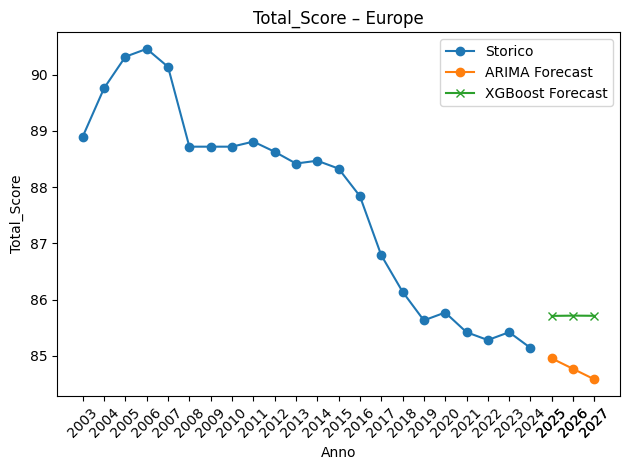

In [ ]:
plot_forecasts(ts_europe, forecast_europe, forecast_xgb_europe, 'Europe')

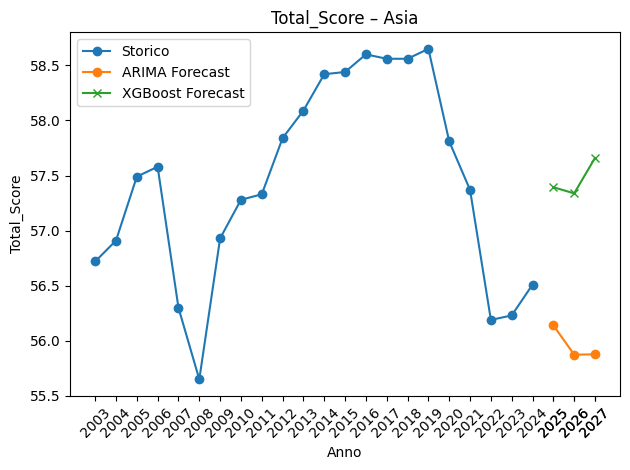

In [ ]:
plot_forecasts(ts_asia, forecast_asia, forecast_xgb_asia, 'Asia')

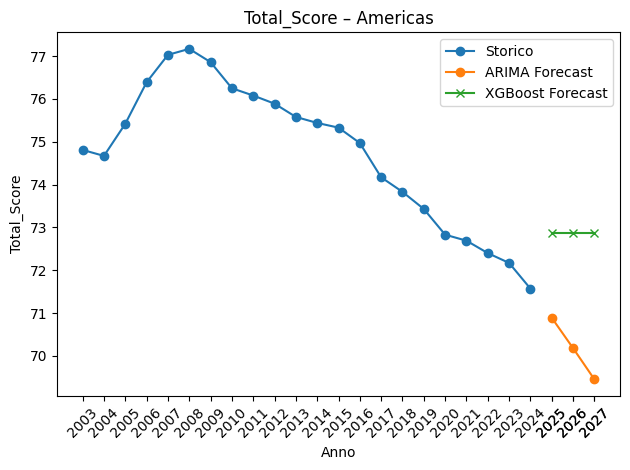

In [ ]:
plot_forecasts(ts_ame, forecast_ame, forecast_xgb_ame, 'Americas')

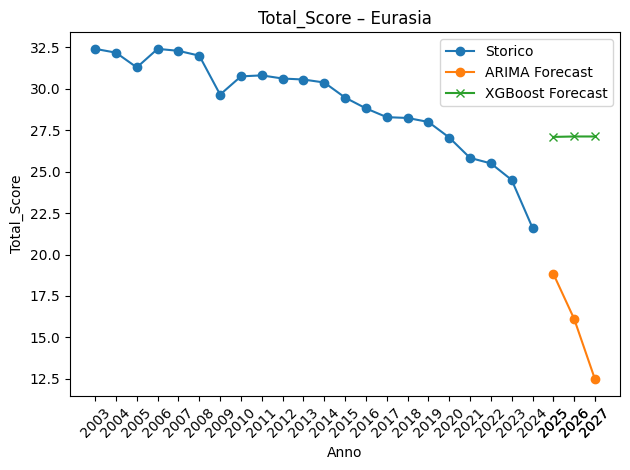

In [ ]:
plot_forecasts(ts_eur, forecast_eurasia, forecast_xgb_eur, 'Eurasia')

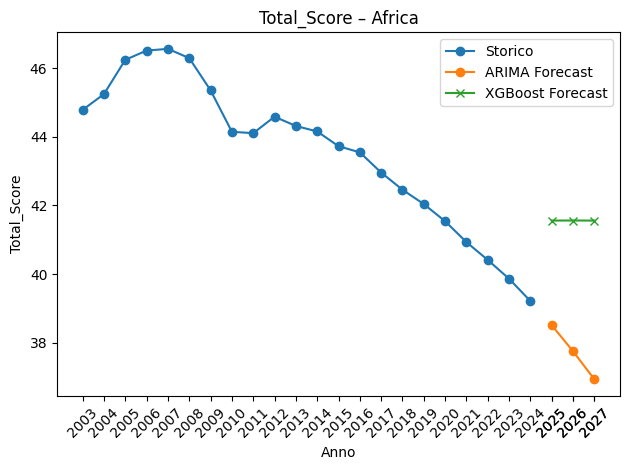

In [ ]:
plot_forecasts(ts_africa, forecast_africa, forecast_xgb_africa, 'Africa')

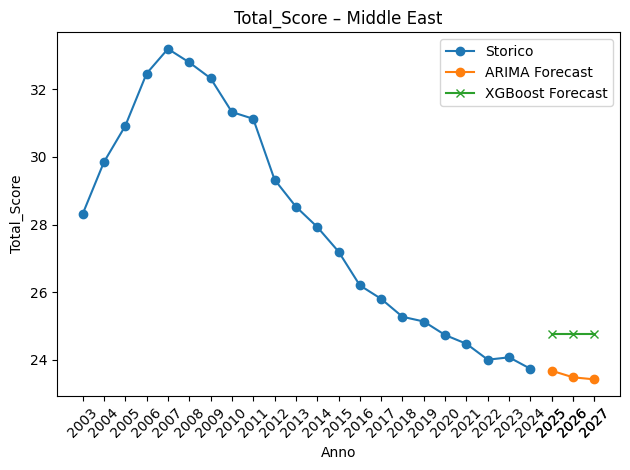

In [ ]:
plot_forecasts(ts_meast, forecast_meast, forecast_xgb_meast, 'Middle East')